# Исследование для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

`Цель:` создать инструмент, выявления токсичных комментариев.

`План:`

1. Загрузка и изучение данных.
2. Предобработка.
3. Обучение различных моделей классифицировать комментарии на позитивные и негативные, подбор гиперпараметров.
4. Тестирование.
5. Отбор наиболее подходящего инструмента с учетом метрики.


`Исходные данные:` файл toxic_comments.csv 
- Столбец text содержит текст комментария, а toxic — целевой признак.

`Метрика:` метрика качества F1

`Условие  принятия:` значение метрики качества не меньше 0.75.


## Загрузка и изучение данных.

### Импорт библиотек и датасета

In [1]:
import pandas as pd
import string
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

import re
# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from itertools import product

In [2]:
#comments = pd.read_csv('datasets/toxic_comments.csv')

In [2]:
#

comments = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Изучение данных

In [3]:
comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Данные соответствующих типов, пропуски отсутствуют.

In [5]:
comments['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

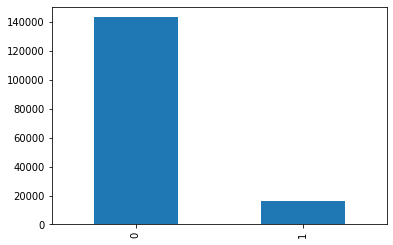

In [6]:
comments['toxic'].value_counts().plot(kind='bar');

Дисбаланс классов: распределение классов несимметричное.

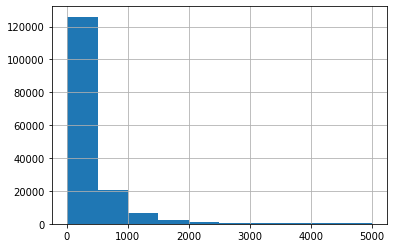

In [7]:
comments['text'].str.len().hist();

In [8]:
max_len = comments['text'].str.len().max()
max_len

5000

Максимальная длина комментария 5000.

## Предобработка

In [9]:
comments['text'] = comments['text'].str.lower()

In [10]:
comments.head(10)

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0
5,"""\n\ncongratulations from me as well, use the ...",0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [11]:
corpus = list(comments['text'])

In [12]:
stop_words = set(nltk_stopwords.words('english'))

In [13]:
# Функция очистки текста
def clear_text(text):
    clear_txt = re.sub(r'[^a-zA-Z]',' ',text)
    token_clear = clear_txt.split() 
    #clear = " ".join(split)
    return token_clear

In [14]:
# Функция лемматизации
def lemmatize(text):
    token_clear = clear_text(text)
    lemmatizer = WordNetLemmatizer()
    lemm_list = map(lambda token: lemmatizer.lemmatize(token, wordnet.VERB), token_clear)
    lemm_text = " ".join(lemm_list)
    return lemm_text




In [15]:
print("Исходный текст:", comments['text'][0])
print('Очищенный:',clear_text(corpus[0]))
print("Очищенный и лемматизированный текст:", lemmatize(corpus[0]))

Исходный текст: explanation
why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27
Очищенный: ['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'weren', 't', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'don', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'm', 'retired', 'now']
Очищенный и лемматизированный текст: explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalisms just closure on some gas after i vote at new york dolls fac and please don t remove the template from the talk page since i m retire now


In [16]:
comments['text_clean'] = comments['text'].map(lemmatize)

In [17]:
comments.head()

,text,toxic,text_clean
0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


In [18]:
# Разделение данных

#features = comments['text_clean']
#target = comments['toxic']

train, valid = train_test_split(comments,test_size=0.4,shuffle = False)
valid, test = train_test_split(comments,test_size=0.5,shuffle = False)

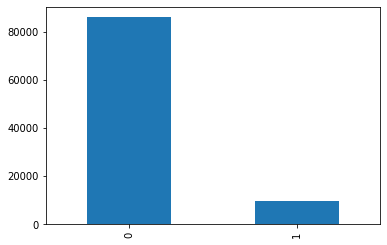

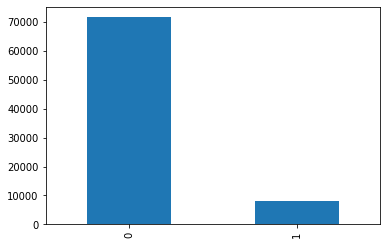

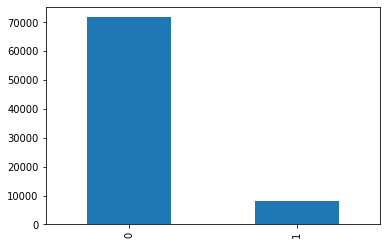

In [19]:
list_df = [train,valid,test]
for df in list_df:
    df['toxic'].value_counts().plot(kind='bar');
    plt.show()


In [20]:
train

,text,toxic,text_clean
0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
95737,"wehwalt, ftr, i'm not objecting to text about ...",0,wehwalt ftr i m not object to text about the p...
95738,"""*::::::::i believe that you're confusing """"pr...",0,i believe that you re confuse precision with a...
95739,but isnt it against the rules to edit if you a...,0,but isnt it against the rule to edit if you be...
95740,"""\nseems about right. nableezy - """,0,seem about right nableezy


In [21]:
# Разделим на корпус и таргет

train_corpus = train['text_clean']#.values.astype('U')
target_train = train['toxic']

valid_corpus = valid['text_clean']#.values.astype('U')
valid_target = valid['toxic']

test_corpus = test['text_clean']#.values.astype('U') 
test_target = test['toxic'] 


In [22]:
#  TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train =count_tf_idf.fit_transform(train_corpus)

tf_idf_valid =count_tf_idf.transform(valid_corpus)
tf_idf_test =count_tf_idf.transform(test_corpus)

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы valid:", tf_idf_valid.shape)
print("Размер матрицы test:", tf_idf_test.shape)



Размер матрицы train: (95742, 115127)
Размер матрицы valid: (79785, 115127)
Размер матрицы test: (79786, 115127)


## Обучение моделей

### Random Forest

In [23]:
forrest = RandomForestClassifier(random_state=420)
param_grid = { 
    'n_estimators': [1,10],    
    'max_depth' : [6,7,8]}

#grid = GridSearchCV(forrest, param_grid, scoring='f1', cv=5)
#grid.fit(tf_idf_train, target_train)
forrest = RandomForestClassifier(max_depth=8, n_estimators=1, random_state=420)


RandomForestClassifier(max_depth=8, n_estimators=1, random_state=420)

In [25]:
forrest.fit(tf_idf_train, target_train)
result_valid_forrest = f1_score(valid_target,forrest.predict(tf_idf_valid))
result_valid_forrest

0.07184511313272685

### LogisticRegression

In [28]:
log_reg = LogisticRegression()

parameters = {'max_iter':[5,10,50],
              'solver': ['liblinear', 'sag', 'saga'], 
             }
#grid = GridSearchCV(estimator=log_reg, param_grid = parameters, cv = 5)
#grid.fit(tf_idf_train, target_train)


In [29]:
grid.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=1, random_state=420)

In [26]:
log_reg = LogisticRegression(max_iter=5, solver='saga')
log_reg.fit(tf_idf_train, target_train)

LogisticRegression(max_iter=5, solver='saga')

In [27]:
result_valid_log_reg = f1_score(valid_target,log_reg.predict(tf_idf_valid))
result_valid_log_reg

0.7592619926199261

### CatBoostClassifier

In [32]:
cat_model = CatBoostClassifier(early_stopping_rounds=10, random_state=420)

In [33]:
grid = {'learning_rate': [0.05],
        'depth': [4, 6, 10]}

In [ ]:
#grid_search_result = cat_model.grid_search(grid, 
#                                       X=tf_idf_train, 
#                                       y=target_train, 
#                                       stratified=True,
#                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6414245	test: 0.6411998	best: 0.6411998 (0)	total: 1.09s	remaining: 18m 5s
1:	learn: 0.5974228	test: 0.5971423	best: 0.5971423 (1)	total: 1.94s	remaining: 16m 8s
2:	learn: 0.5564226	test: 0.5559204	best: 0.5559204 (2)	total: 2.92s	remaining: 16m 9s
3:	learn: 0.5217390	test: 0.5211190	best: 0.5211190 (3)	total: 3.74s	remaining: 15m 30s
4:	learn: 0.4913705	test: 0.4907363	best: 0.4907363 (4)	total: 4.58s	remaining: 15m 10s
5:	learn: 0.4632748	test: 0.4625672	best: 0.4625672 (5)	total: 5.43s	remaining: 15m
6:	learn: 0.4387028	test: 0.4378211	best: 0.4378211 (6)	total: 6.33s	remaining: 14m 58s
7:	learn: 0.4156462	test: 0.4147125	best: 0.4147125 (7)	total: 7.23s	remaining: 14m 56s
8:	learn: 0.3964861	test: 0.3955162	best: 0.3955162 (8)	total: 8.14s	remaining: 14m 56s
9:	learn: 0.3795745	test: 0.3786408	best: 0.3786408 (9)	total: 9.04s	remaining: 14m 55s
10:	learn: 0.3645356	test: 0.3633245	best: 0.3633245 (10)	total: 9.95s	remaining: 14m 54s
11:	learn: 0.3506963	test: 0.3494793	

### LinearSVC

In [28]:
for i in product([{'C':0.1},{'C':1.0} ,{'C':2.5}],
              [{'max_iter':5},{ 'max_iter':10}, {'max_iter':100}]
              ):
    model_svc = LinearSVC(random_state = 420,**i[0],**i[1])
    model_svc.fit(tf_idf_train, target_train)
    predicted_svc = model_svc.predict(tf_idf_valid)
    
    print('i=', i, 'f1_svc', f1_score(valid_target, predicted_svc))

i= ({'C': 0.1}, {'max_iter': 5}) f1_svc 0.7690504103165299
i= ({'C': 0.1}, {'max_iter': 10}) f1_svc 0.7674230740985533
i= ({'C': 0.1}, {'max_iter': 100}) f1_svc 0.7675135849610809
i= ({'C': 1.0}, {'max_iter': 5}) f1_svc 0.9301321138211381
i= ({'C': 1.0}, {'max_iter': 10}) f1_svc 0.9365069316958915
i= ({'C': 1.0}, {'max_iter': 100}) f1_svc 0.9337403026834542
i= ({'C': 2.5}, {'max_iter': 5}) f1_svc 0.9378856437679967
i= ({'C': 2.5}, {'max_iter': 10}) f1_svc 0.9463878326996197
i= ({'C': 2.5}, {'max_iter': 100}) f1_svc 0.9655044050130289


In [29]:
model_svc = LinearSVC(random_state = 420,C= 2.5, max_iter= 100)
model_svc.fit(tf_idf_train, target_train)
predicted_svc = model_svc.predict(tf_idf_valid)
result_model_svc = f1_score(valid_target, predicted_svc)
    
   

In [30]:
result_models = {'LinearRegression':[result_valid_log_reg],
                 'LinearSVC':[result_model_svc],
                 'RandomForestClassifier':[result_valid_forrest]}
results = pd.DataFrame(result_models)
results

,LinearRegression,LinearSVC,RandomForestClassifier
0,0.759262,0.965504,0.071845


## Тестирование 

In [31]:
model_list = [model_svc,forrest,log_reg]
for model in model_list:
    print(model)
    print(f1_score(test_target,model.predict(tf_idf_test)))
    print()

LinearSVC(C=2.5, max_iter=100, random_state=420)
0.8111869396494046

RandomForestClassifier(max_depth=8, n_estimators=1, random_state=420)
0.07026318923425032

LogisticRegression(max_iter=5, solver='saga')
0.7308220222662803



### Вывод

В ходе исследования было сделано следующее:

1. Загружены и изучены данные.
2. Проведена предобработка.
3. Обучены различные модели, подобраны гиперпараметры.
4. Тестирование.
5. Наиболее подходящая модель: LinearSVC  0.8111